In [22]:
from SBTS import *
from schemes import *
from tools import *
from metrics import *

The final case study allows us to evaluate the ability of the generator to account for stochastic volatility.
To this end, we consider the Heston model, in which the instantaneous variance process $v$ is assumed to follow a CIR process. Formally, the multivariate time series
$X = (S, v)$ is governed by the following system of stochastic differential equations:
\begin{align*}
dS_t &= r S_t, dt + \sqrt{v_t}, S_t, dW_t^{(1)},\\
dv_t &= \kappa(\theta - v_t), dt + \xi \sqrt{v_t}, dW_t^{(2)}, \\
d\langle W^{(1)}, W^{(2)} \rangle_t &= \rho, dt,
\end{align*}
where $\kappa > 0$ is the speed of mean reversion, $\theta > 0$ the long-term variance level, $\xi > 0$ the volatility of volatility, r the risk-free rate, and
$\rho \in [-1,1]$ the correlation between the Brownian motions. We set $S_0 = v_0 = 1$.

Under standard regularity conditions on the instantaneous variance process $(v_t)_{t \ge 0}$, applying Itô’s formula to $f(x) = \ln x$ yields
$$S_{t+\Delta} = S_t \exp\left(\int_t^{t+\Delta} \left(r - \frac{v_s}{2}\right)\, ds + \int_t^{t+\Delta} \sqrt{v_u}\, dW_u^{(1)} \right).$$
For sufficiently small $\Delta$, the following approximations are relevant:
$$\int_t^{t+\Delta} \left(r - \frac{v_s}{2}\right)\, ds \approx \left(r - \frac{v_t}{2}\right)\Delta, \qquad \int_t^{t+\Delta} \sqrt{v_u}\, dW_u^{(1)} \approx \sqrt{v_t}\,(W_{t+\Delta}^{(1)} - W_t^{(1)}).$$

As a consequence,
\begin{align*}
Y_t :=
\begin{pmatrix}
\ln\left(\dfrac{S_{t+\Delta}}{S_t}\right) \\
v_{t+\Delta} - v_t
\end{pmatrix}
\sim \mathcal{N}(\mu_t, \Sigma_t),
\quad
\mu_t :=
\begin{pmatrix}
\left(r - \dfrac{v_t}{2}\right)\Delta \\
\kappa(\theta - v_t)\Delta
\end{pmatrix},
\quad
\Sigma_t :=
\begin{pmatrix}
v_t \Delta & \rho \xi v_t \Delta \\
\rho \xi v_t \Delta & \xi^2 v_t \Delta
\end{pmatrix},
\end{align*}

and the log-likelihood associated with a trajectory
$(S_{t_i}^{(m)}, v_{t_i}^{(m)})_{i=0,\ldots,N}$ is given by
\begin{align*}
    \ell(\kappa, \theta, r, \rho, \xi; S^{(m)}, v^{(m)}) = -\frac 12 \sum_{i=0}^{N-1} \left\{\ln\big(4\pi^2\det(\Sigma_{t_i}^{(m)})\big) + \big(Z_{t_i}^{(m)}\big)^\top \big(\Sigma_{t_i}^{(m)}\big)^{-1}Z_{t_i}^{(m)}\right\},
\end{align*}
where $Z_{t_i}^{(m)} := Y_{t_i}^{(m)} - \mu_{t_i}^{(m)}$.

Note that
\begin{align*}
\det(\Sigma_{t_i}^{(m)}) =
\xi^2 (v_{t_i}^{(m)})^2 \Delta^2 (1 - \rho^2),\quad
\big(\Sigma_{t_i}^{(m)}\big)^{-1} =
\frac{1}{\xi^2 v_{t_i}^{(m)} \Delta (1 - \rho^2)}
\begin{pmatrix}
\xi^2 & -\rho \xi \\
-\rho \xi & 1
\end{pmatrix},
\end{align*}

\begin{align*} \big(Z_{t_i}^{(m)}\big)^\top \big(\Sigma_{t_i}^{(m)}\big)^{-1}Z_{t_i}^{(m)} &= \frac{1}{\xi^2 v_{t_i}^{(m)}\Delta(1-\rho^2)}\Bigg\{\xi^2\left(\ln\left(\frac{S_{t_{i+1}}^{(m)}}{S_{t_i}^{(m)}} \right)- \left(r-\frac{v_{t_i}^{(m)}}{2}\right)\Delta\right)^2 \\
    & -2\rho \xi\left(\ln\left(\frac{S_{t_{i+1}}^{(m)}}{S_{t_i}^{(m)}} \right)- \left(r-\frac{v_{t_i}^{(m)}}{2}\right)\Delta\right)\left(v_{t_{i+1}}^{(m)} - v_{t_i}^{(m)} - \kappa(\theta - v_{t_i}^{(m)})\Delta\right)\\
    & + \left(v_{t_{i+1}}^{(m)} - v_{t_i}^{(m)} - \kappa(\theta - v_{t_i}^{(m)})\Delta\right)^2\Bigg\}
\end{align*}

We further take $M = 100$ reference trajectories, $N = 100$, a time step $\Delta = 1/252$, corresponding to a time horizon $T = 100/252$.
During the generation of synthetic trajectories, the Euler scheme is used with an internal discretization $N_\pi = 100$, and the selected hyperparameters are $(h, r) = ([0.1, 0.15], 10)$.

Once again, the same conclusion as in the Ornstein–Uhlenbeck case holds regarding the choice of the parameter $r$. For more details, see `test_OU.ipynb`. Moreover, we rely on log-returns to generate synthetic time series.

### I. Fixed parameters

#### I.1. Generation of synthetic trajectories

In [54]:
kappa, theta, xi, r, rho = 3.0, 0.02, 0.7, 0.02, 0.7

In [158]:
N = 100
T = N/252
S0 = 1 
Sigma0 = 1
M = 100
delta = T/N

Z = np.random.normal(0.0, 1.0, size = (M, N, 2))
X, v = simulate_heston(M, N, Z, S0, Sigma0, T, r, kappa, theta, xi, rho) 

X_heston = np.stack((X, v), axis = -1)
log_returns = np.zeros((M, N+1, 2))
log_returns[:,1:] = np.diff(np.log(X_heston), axis=1)

In [160]:
h = np.array([0.1, 0.15])        
N_pi = 100
n = 100
vals = simulate_SBTS_trajectories_d(log_returns, n, h, delta, N_pi, x0=np.zeros(2), markov_proj=True, r=10)

100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


In [162]:
vals = np.exp(vals.cumsum(axis=1))

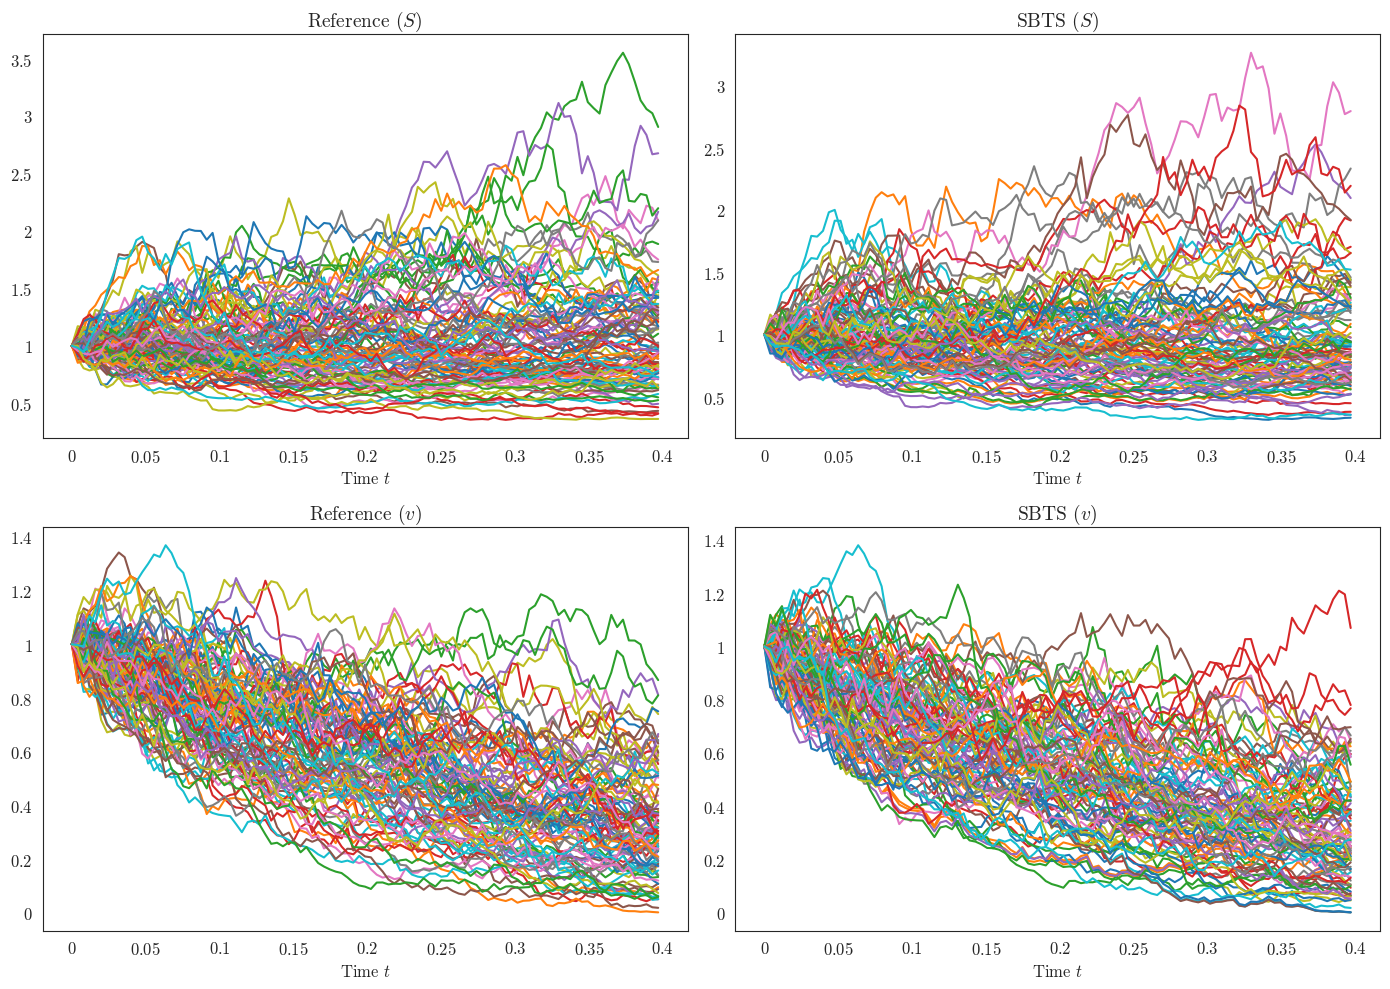

In [182]:
plot_traj_Heston(X_heston, vals, T, N)

#### I.2. Parameters estimation

In [171]:
bounds = np.array([
    (0.1, 230.0),    # kappa
    (1e-4, 1.2),     # theta
    (0.1, 1),        # xi
    (-4, 4),         # r 
    (0.5, 0.80)      # rho 
])

In [173]:
params_opt, info = predict_params_Heston(X, v, delta, bounds)
params_opt = np.array(params_opt)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 120.21it/s]


In [174]:
x0 = np.array([3.0, 0.02, 0.7, 0.02, 0.7])

In [177]:
params_opt_SBTS, info_SBTS  = predict_params_Heston(vals[:, :, 0], vals[:, :, 1], delta, bounds, x0)
params_opt_SBTS = np.array(params_opt_SBTS)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 124.11it/s]


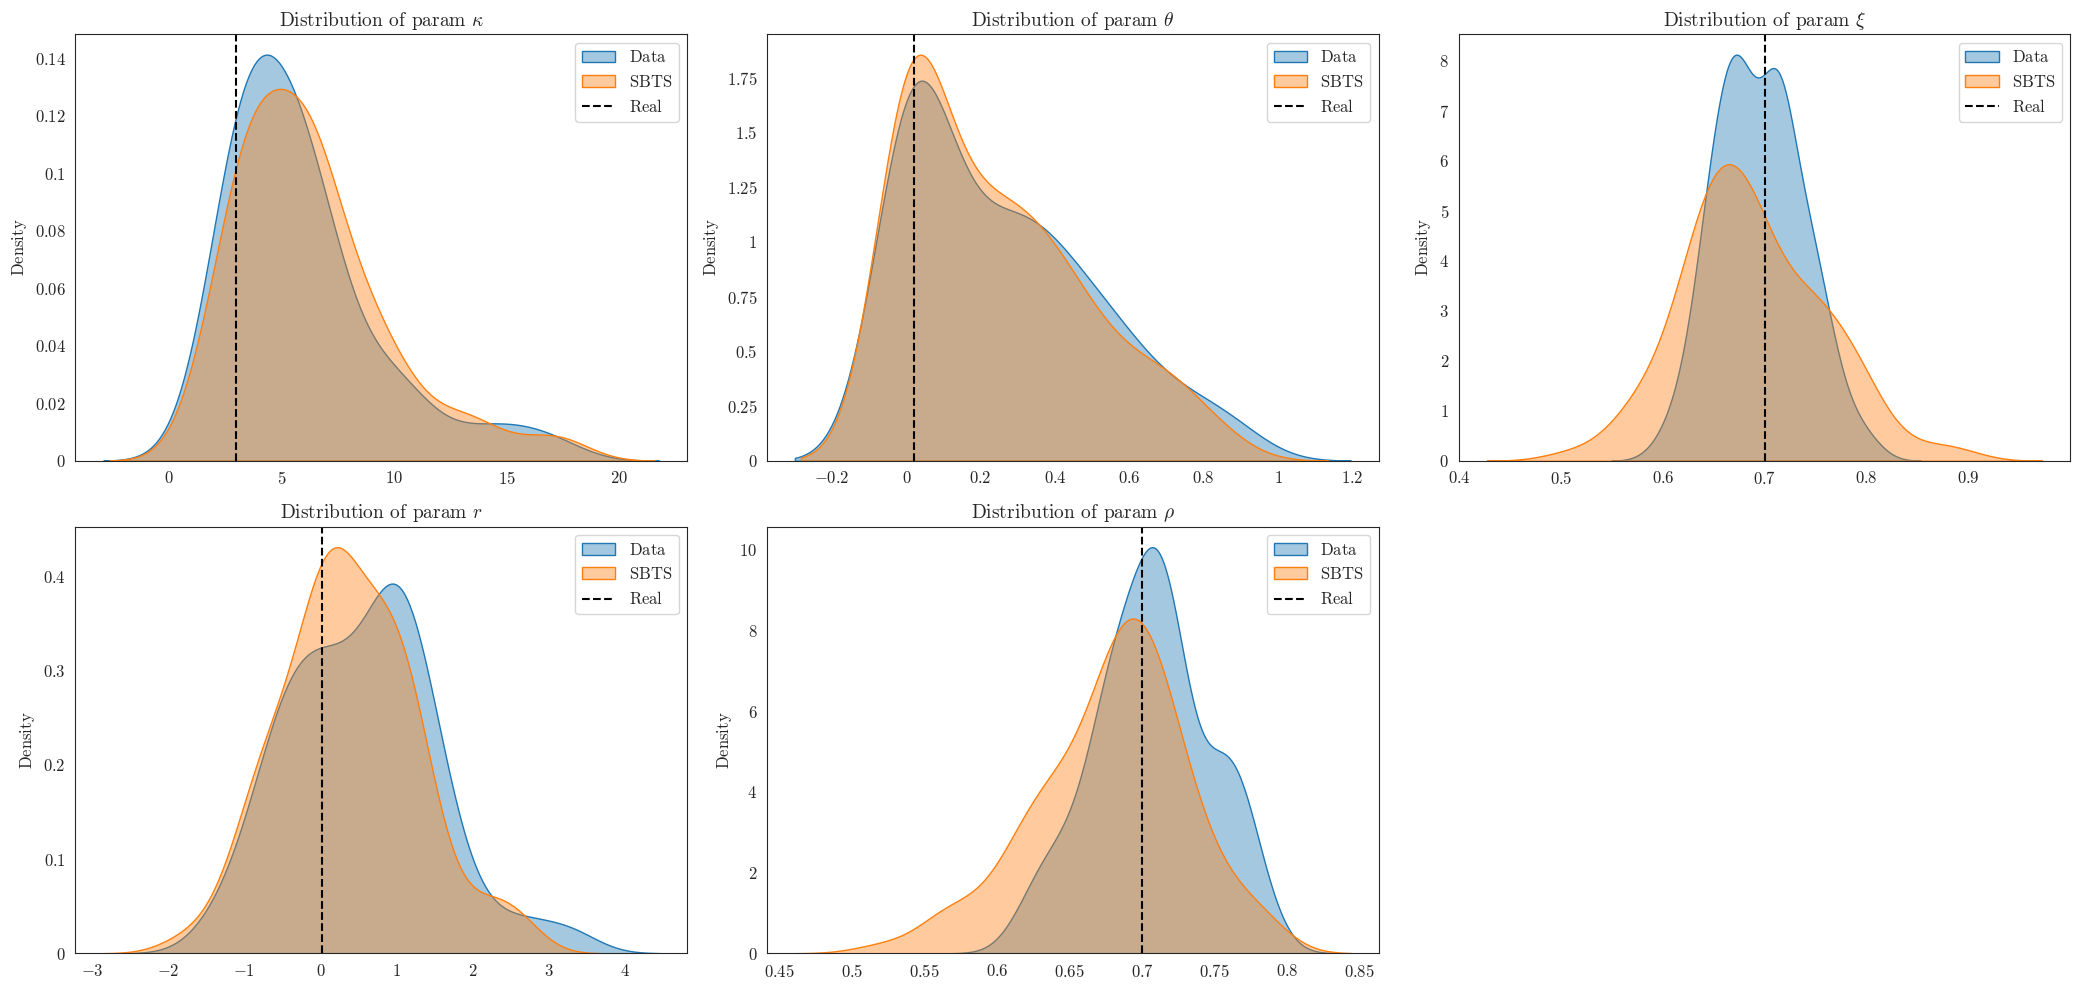

In [179]:
plot_distrib_Heston(kappa, theta, xi, r, rho, params_opt, params_opt_SBTS)

In [80]:
X_heston = np.stack((X, v), axis = -1)

#### I.3. Discriminative score

In [84]:
discriminative_scores, predictive_scores = scores(X_heston, vals, col_pred = None, 
                                                  iterations = 2000, n_temp = 10, min_max = True, both = True)

100%|███████████████████████████████████████████| 10/10 [12:41<00:00, 76.19s/it]

Discriminative score : 0.062 +- 0.048
Predictive score : 0.121 +- 0.025


### II. Random parameters

#### II.1. Generation of synthetic trajectories

In [193]:
N = 100
T = N/252
S0 = 1 
Sigma0 = 1
M = 100
delta = T/N

kappa_random = np.random.uniform(0.5, 4, size = M)
theta_random = np.random.uniform(0.5, 1.5, size = M) 
xi_random = np.random.uniform(0.01, 0.9, size = M) 
rho_random = np.random.uniform(-0.9, 0.9, size = M) 
r_random = np.random.uniform(0.02, 0.1, size = M) 

Z_random = np.random.normal(0.0, 1.0, size = (M, N, 2))
X_random,  v_random = simulate_heston(M, N, Z_random, S0, Sigma0, T, r_random, kappa_random, theta_random, xi_random, rho_random)

In [214]:
X_heston_random = np.stack((X_random, v_random), axis = -1)
log_returns_random = np.zeros((M, N+1, 2))
log_returns_random[:,1:] = np.diff(np.log(X_heston_random), axis=1)

In [197]:
h = np.array([0.1,0.1])
n = 100
N_pi = 100
vals_random = simulate_SBTS_trajectories_d(log_returns_random, n, h, delta, N_pi, x0=np.zeros(2), markov_proj=True, r=1)

100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.35it/s]


In [199]:
vals_random = np.exp(vals_random.cumsum(axis=1))

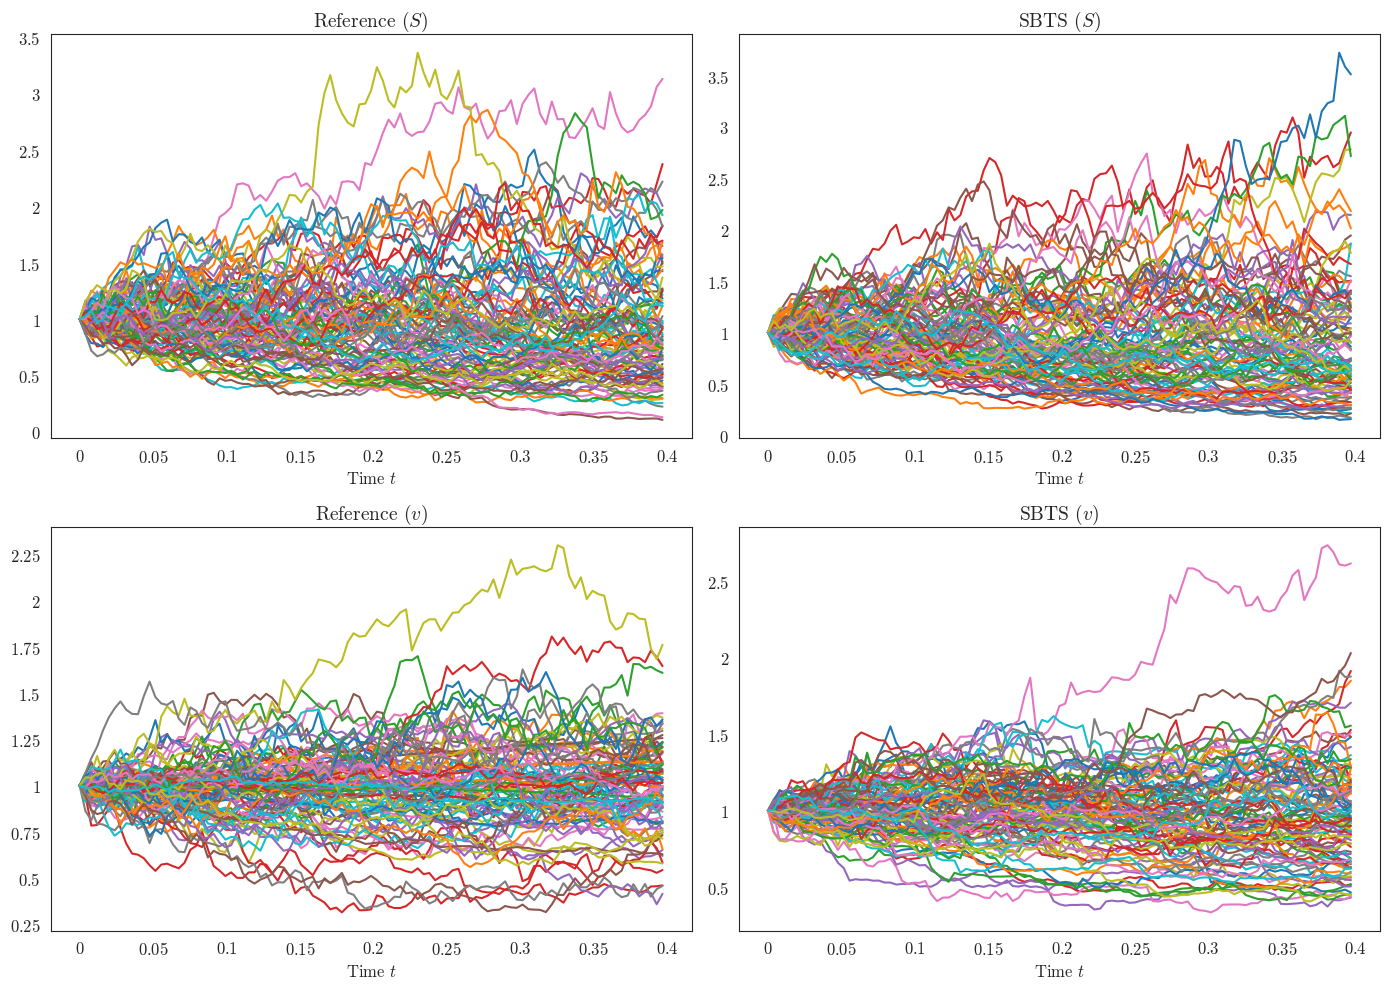

In [201]:
plot_traj_Heston(X_heston_random, vals_random, T, N)

#### II.2. Parameters estimation

In [203]:
bounds_random = np.array([
    (1e-6, 40),      # kappa
    (1e-6, 3),       # theta
    (1e-6, 1),       # xi 
    (-1, 1),         # r 
    (-0.95, 0.95)    # rho
])

In [205]:
params_opt_random, info_random = predict_params_Heston(X_random, v_random, delta, bounds_random)
params_opt_random = np.array(params_opt_random)
params_opt_random.shape

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 87.75it/s]


(5, 100)

In [206]:
params_opt_SBTS_random, info_SBTS_random = predict_params_Heston(vals_random[:, :, 0], vals_random[:, :, 1], delta, bounds_random)
params_opt_SBTS_random = np.array(params_opt_SBTS_random)
params_opt_SBTS_random.shape

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 108.40it/s]


(5, 100)

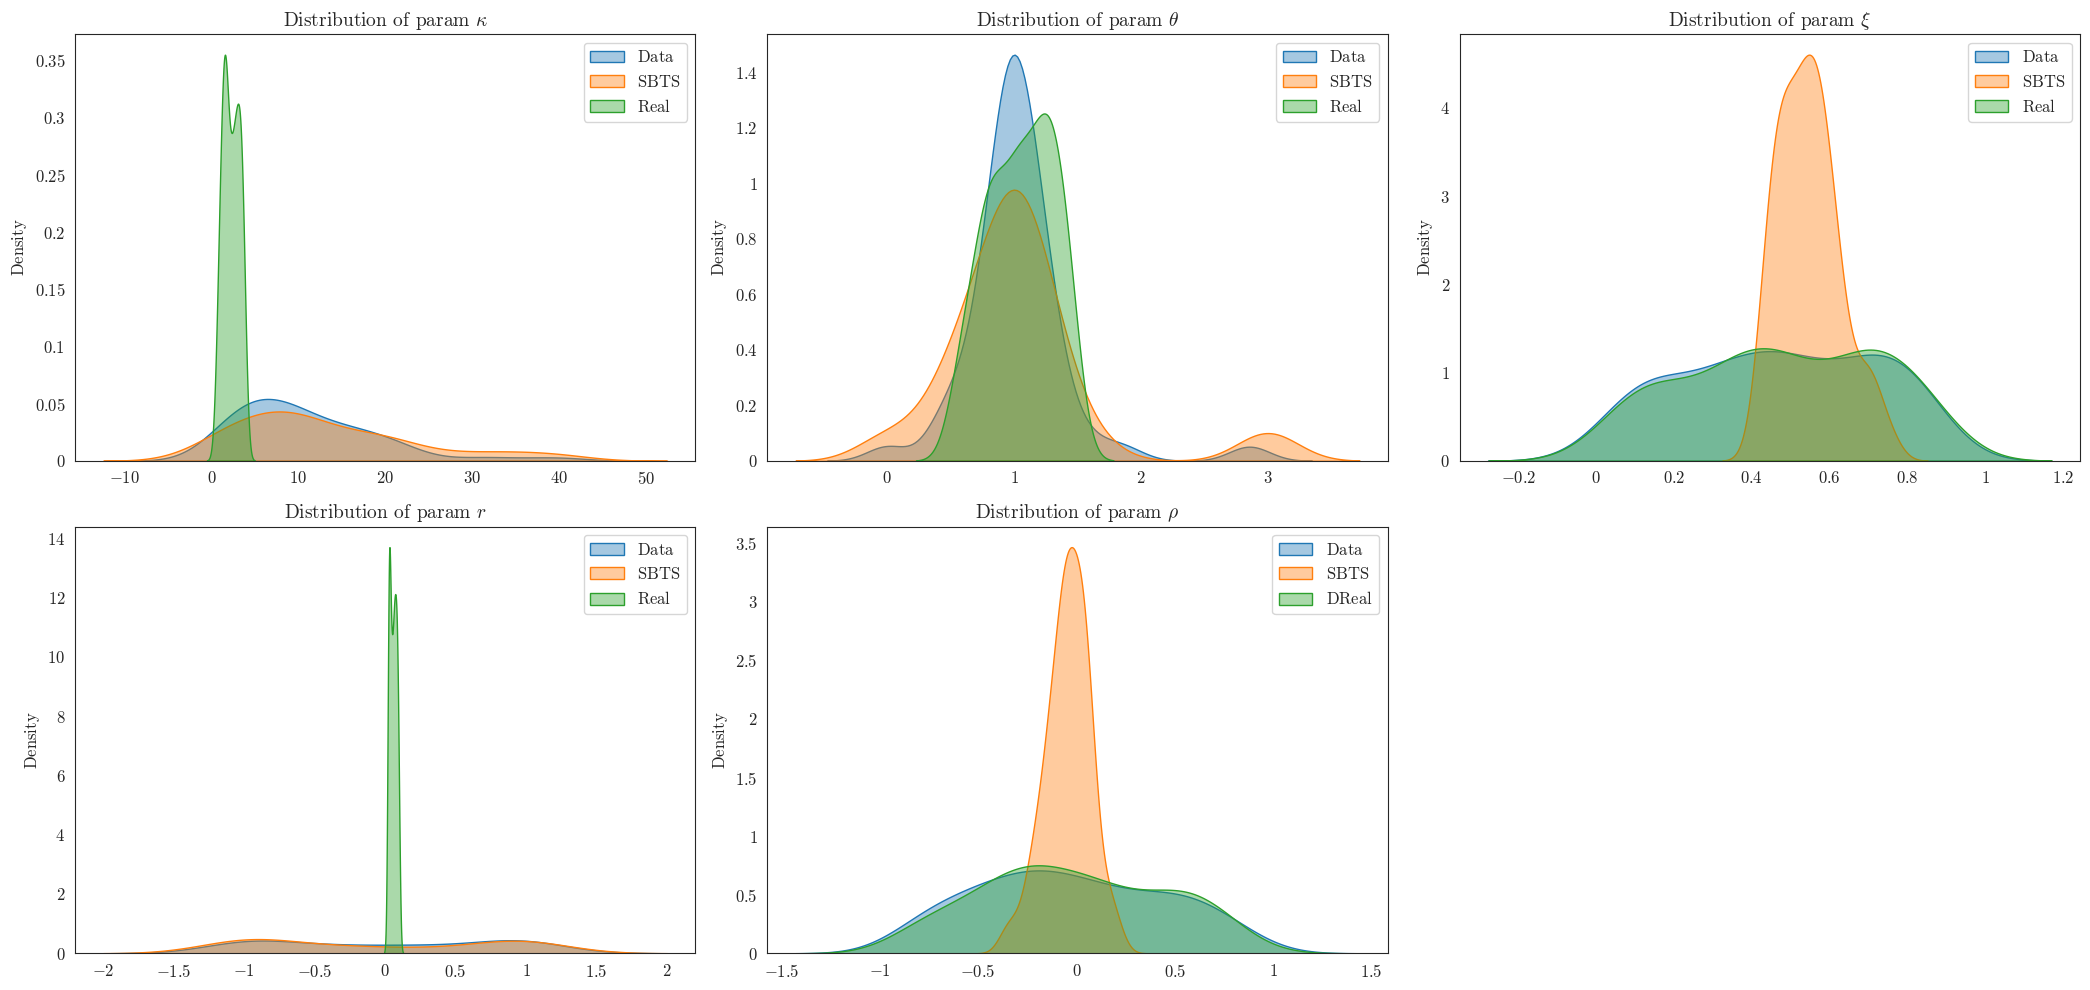

In [209]:
plot_distrib_Heston_random(kappa_random, theta_random, xi_random, r_random, rho_random, params_opt_random, params_opt_SBTS_random)

The estimation of the parameters $(\kappa, \theta, r)$ is satisfactory. However, the synthetic trajectories fail to accurately recover the parameters governing volatility variability, namely $\xi$ and $\rho$. This limitation stems from the constant-variance assumption underlying the SBTS process, which is not compatible with a stochastic volatility dynamics such as the Heston model. From a theoretical perspective, this discrepancy arises because the Heston measure $\mathbb{P}_{\text{Heston}}$ is not absolutely continuous with respect to the chosen reference measure, namely the Wiener measure $\mathbb{W}$.

#### II.3. Discriminative score

In [212]:
X_heston_random = np.stack((X_random, v_random), axis = -1)

In [113]:
discriminative_scores_random, predictive_scores_random = scores(X_heston_random, vals_random, col_pred = None, 
                                                  iterations = 2000, n_temp = 10, min_max = True, both = True)

100%|███████████████████████████████████████████| 10/10 [11:42<00:00, 70.26s/it]

Discriminative score : 0.04 +- 0.025
Predictive score : 0.105 +- 0.004
